In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Note: TO RUN THIS SCRIPT, NEED TO BE IN CONDA ENVIRONMENT geopandas
# because of conflicts between geopandas and other packages
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from shapely.geometry import box, mapping
import rioxarray
from rasterio import features
from affine import Affine
import pickle

In [ ]:
# Root directory: change to where data downloaded to
root_dir = '/data2/jbaldwin/WCAS2023'

In [3]:
#Bounding Box for Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['latitude'], coords['longitude'])
    out_shape = (len(coords['latitude']), len(coords['longitude']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))


In [4]:
# Wind field data for the grid
ds_exp = xr.open_dataset(root_dir+'/HAZARD/WIND_SWATHS/IBTrACS/wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_3-8-21.nc')#.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))


In [6]:
# Create region mask based on natural earth data
# this shapefile is from natural earth data
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
states = gpd.read_file(root_dir+'/REGION_MASKS/ne_10m_admin_1_states_provinces_lakes.shp')
us_states = states.query("admin == 'Philippines'").reset_index(drop=True)
state_ids = {k: i for i, k in enumerate(us_states.woe_name)}
shapes = [(shape, n) for n, shape in enumerate(us_states.geometry)]

ds = xr.Dataset(coords={'longitude': np.linspace(lonmin, lonmax, num=5000),
                          'latitude': np.linspace(latmin, latmax, num=3000)})
ds['states'] = rasterize(shapes, ds.coords)

# example of applying a mask
#ds.states.where(ds.states == state_ids['California']).plot()

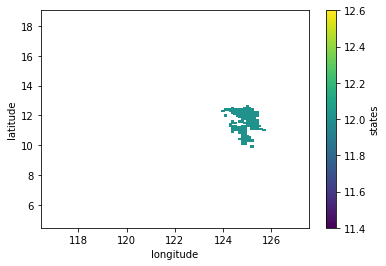

In [5]:
# shapefile from the Philippines government
states = gpd.read_file(root_dir+'/REGION_MASKS/PHL_AdminBoundaries_candidate_exclude_adm3.gdb')
phi_states = states.reset_index(drop=True)
state_ids = {k: i for i, k in enumerate(phi_states.admin1AltName1_en)}
shapes = [(shape, n) for n, shape in enumerate(phi_states.geometry)]

ds = xr.Dataset(coords={'longitude': ds_exp.lon.values,
                          'latitude': ds_exp.lat.values})
ds['states'] = rasterize(shapes, ds.coords)

# example of applying a mask
ds.states.where(ds.states == state_ids['Eastern Visayas']).plot()

ds.to_netcdf(root_dir+'/REGION_MASKS/philippines_province_masks_windfield.nc')

In [10]:
pickle.dump( state_ids, open( root_dir+"/REGION_MASKS/state_ids.p", "wb" ) )